## Import Libraries

In [62]:
import pandas
import matplotlib.pyplot as plt
import os
import time
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array

## Prepare DataLoaders

In [64]:
class_names = [('no_tumor', 0), ('meningioma_tumor', 1), ('glioma_tumor', 2), ('pituitary_tumor', 3)]

X_train = []
Y_train = []

for tumor, idx in class_names:
    path = f'../input/brain-tumor-classification-mri/Training/{tumor}'
    for img in os.listdir(path):
      image = load_img(path + '/' + img, color_mode = 'grayscale', target_size = (150, 150), interpolation = 'nearest')
      X_train.append(img_to_array(image))
      Y_train.append(idx)

X_test = []
Y_test = []

for tumor, idx in class_names:
    path = f'../input/brain-tumor-classification-mri/Testing/{tumor}'
    for img in os.listdir(path):
      image = load_img(path + '/' + img, color_mode = 'grayscale', target_size = (150, 150), interpolation = 'nearest')
      X_test.append(img_to_array(image))
      Y_test.append(idx)

## Standardise Dataset

In [65]:
X_train = np.array(X_train)
X_train /= 255.0 # RGB channel

Y_train = np.array(keras.utils.to_categorical(Y_train))

X_test = np.array(X_test)
X_test /= 255.0

Y_test = np.array(keras.utils.to_categorical(Y_test))

In [103]:
classes = {0 : 'Glioma Tumor', 1 : 'Meningioma Tumor', 2 : 'Normal', 3 : 'Pituitary Tumor'}

# Preview and Slice Dataset

In [102]:
def preview_data():
    plt.figure(figsize = (12,12))
    for i in range(6) :
        # subplot
        plt.subplot(331 + i)
        x = np.random.randint(0, 500)
    
        # plot the figure
        plt.imshow(X_train[x])
        plt.title(classes[np.argmax(Y_train[x])], fontsize = 14)
        plt.axis('on')
        plt.grid()
    plt.show()

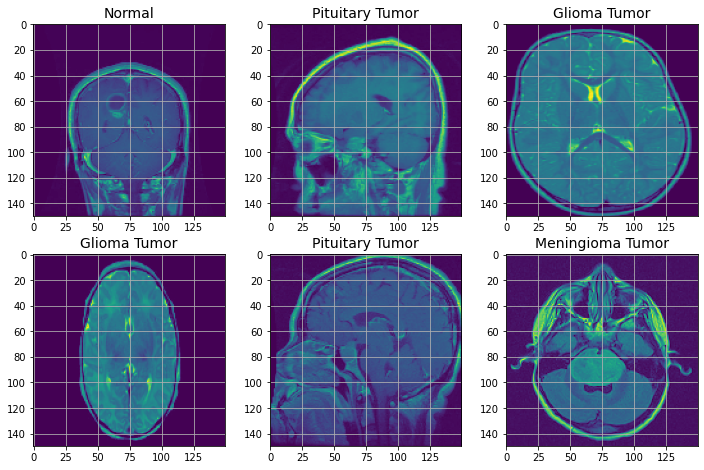

In [104]:
preview_data()

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state=42)
print("X_train Shape: ",X_train.shape)
print("X_test Shape:",X_test.shape)
print("Y_train Shape: ",Y_train.shape)
print("Y_test Shape:",Y_test.shape)

X_train Shape:  (2296, 150, 150, 1)
X_test Shape: (574, 150, 150, 1)
Y_train Shape:  (2296, 4)
Y_test Shape: (574, 4)


## Creating the Model

In [76]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

# Layer 1
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# Layer 4
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# Layer 5
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999) # Adam Optimization Algorithm
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 25  
batch_size = 50

model.summary() 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 64)      1664      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 128)      

In [77]:
datagen = ImageDataGenerator(
        featurewise_center = False,  
        samplewise_center = False, 
        featurewise_std_normalization = False,  
        samplewise_std_normalization = False,  
        zca_whitening = False,  
        rotation_range = 0,
        zoom_range = 0,
        width_shift_range = 0,  
        height_shift_range = 0,  
        horizontal_flip = True,  
        vertical_flip = False) 

In [78]:
start_time = time.time()
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test, Y_test),
                              steps_per_epoch = X_train.shape[0] // batch_size) 
end_time = time.time()
print(end_time - start_time)

Epoch 1/25
45/45 [==============================] - 144s 3s/step - loss: 1.3113 - accuracy: 0.3798 - val_loss: 1.1071 - val_accuracy: 0.5070
Epoch 2/25
45/45 [==============================] - 137s 3s/step - loss: 0.9923 - accuracy: 0.5891 - val_loss: 0.8748 - val_accuracy: 0.6516
Epoch 3/25
45/45 [==============================] - 137s 3s/step - loss: 0.8531 - accuracy: 0.6466 - val_loss: 0.8091 - val_accuracy: 0.6638
Epoch 4/25
45/45 [==============================] - 141s 3s/step - loss: 0.7951 - accuracy: 0.6553 - val_loss: 0.7533 - val_accuracy: 0.6324
Epoch 5/25
45/45 [==============================] - 136s 3s/step - loss: 0.6247 - accuracy: 0.7279 - val_loss: 0.8260 - val_accuracy: 0.6359
Epoch 6/25
45/45 [==============================] - 136s 3s/step - loss: 0.6177 - accuracy: 0.7408 - val_loss: 0.7238 - val_accuracy: 0.6760
Epoch 7/25
45/45 [==============================] - 135s 3s/step - loss: 0.5590 - accuracy: 0.7605 - val_loss: 0.5778 - val_accuracy: 0.7561
Epoch 8/25
45

## Accuracy Visualisation

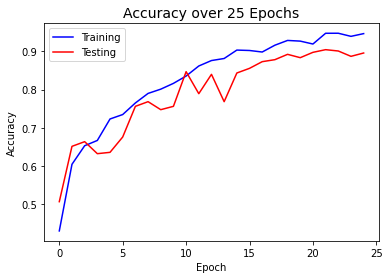

In [85]:
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "red")

plt.title("Accuracy over 25 Epochs", fontsize = 14)
plt.legend(["Training", "Testing"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()